### Кредитный скоринг

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

In [109]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\anaconda\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['diff', 'exp']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [110]:
credit = pd.read_csv('credit_card_default_analysis.csv')
credit

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,0,0,0,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [111]:
len(credit)

30000

In [112]:
a = [1,1,1]
b = [2,2,3]
#A[:len(A)/2]
a[:int(len(a)/3)]


[1]

##### Данные о кредитных историях клиентов одного из банков:

LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)

SEX: пол клиента (1 = мужской, 2 = женский )

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 

AGE: возраст в годах

PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 

PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 

default - индикатор невозврата денежных средств (0 -вернули кредит, 1- не вернули)

#### 1
Разделим людей на две группы: тех, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1). Построим гистограммы с зависимостью количества людей, выплативших или не выплативших кредит, от кридитного лимита. 

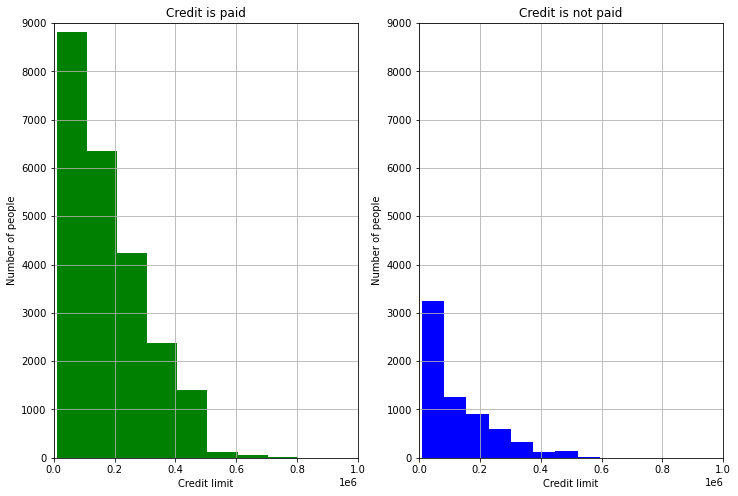

In [113]:
credit_return = credit[credit['default']==0] #вернули кредит
credit_not_return = credit[credit['default']==1] #не вернули кредит

pylab.figure(figsize=(12,8))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(credit_return.LIMIT_BAL, color = 'g')
pylab.xlim(0,1000000)
pylab.ylim(0,9000)
pylab.xlabel('Credit limit')
pylab.ylabel('Number of people')
pylab.title('Credit is paid')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(credit_not_return.LIMIT_BAL, color = 'b')
pylab.xlim(0,1000000)
pylab.ylim(0,9000)
pylab.xlabel('Credit limit')
pylab.ylabel('Number of people')
pylab.title('Credit is not paid')

pylab.show()

Из графиков видно, что в основном, кредиты не возвращают люди с маленьким кредитным лимитом. При этом в приницпе количество людей с маленьким кредитным лимитом больше, чем с большим. Во всяком случае, лучше сравнивать группы людей, вернувших и не вернувших кредиты, не с помощью графиков, а с помощью критериев.

Теперь для этих двух групп проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.

Нулевая гипотеза $H_0$ - медианные значения первой и второй группы равны

Двусторонняя альтернатива $H_1$ - не равны

Для начала используем просто двувыборончый критерий для независимых выборок

In [114]:
print('95%% доверительный интервал для группы людей, выплативших кредит: [%f, %f]' % zconfint(credit_return.LIMIT_BAL))
print('95%% доверительный интервал для группы людей, не выплативших кредит: [%f, %f]' % zconfint(credit_not_return.LIMIT_BAL))

95% доверительный интервал для группы людей, выплативших кредит: [176411.914497, 179787.537651]
95% доверительный интервал для группы людей, не выплативших кредит: [127333.653340, 132885.659499]


Для более точной проверки гипотезы воспользуемся также методом бутстрепа

In [115]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
print('95%% доверительный интервал для группы людей, выплативших кредит:', stat_intervals(get_bootstrap_samples(np.array(credit_return.LIMIT_BAL), 1000).mean(axis = 1), 0.05))
print('95%% доверительный интервал для группы людей, не выплативших кредит:', stat_intervals(get_bootstrap_samples(np.array(credit_not_return.LIMIT_BAL), 1000).mean(axis = 1), 0.05))

95%% доверительный интервал для группы людей, выплативших кредит: [176514.75560692 179898.2836843 ]
95%% доверительный интервал для группы людей, не выплативших кредит: [127249.22031344 132905.4005425 ]


Оба способа показывают, что 95% доверительные интервалы для медиан в группах людей вернувших или невернувших кредит не пересекаются, а значит гипотеза о их равенстве отвергается. 

Теперь проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

Нулевая гипотеза $H_0$ - распределения выборок людей, вернувших и невернувыших кредит, равны

Двусторонняя альтернатива $H_1$ -  не равны

Воспольщуемся перестановочным критерием

In [116]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [117]:
print('p-value:', permutation_test(credit_return.LIMIT_BAL, credit_not_return.LIMIT_BAL, max_permutations=1000))

p-value: 0.001


Так как достиагемый уровень значимости равен 0.01, то на уровне 0.05 наша нулевая гипотеза отвергается

Результат практически значим, так как медианы в группах людей вернувших и невернувшх кредит сильно отличаются друг от друга.

##### 2
Теперь проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

Нулевая гипотеза $H_0$ - гендерный состав отличается

Двусторонняя альтернатива $H_1$ -  не отличается

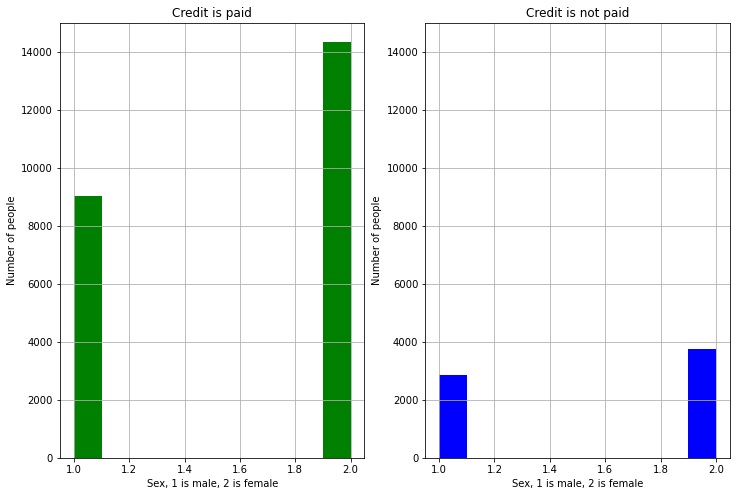

In [118]:
pylab.figure(figsize=(12,8))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(credit_return.SEX, color = 'g')
pylab.ylim(0,15000)
pylab.xlabel('Sex, 1 is male, 2 is female')
pylab.ylabel('Number of people')
pylab.title('Credit is paid')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(credit_not_return.SEX, color = 'b')
pylab.ylim(0,15000)
pylab.xlabel('Sex, 1 is male, 2 is female')
pylab.ylabel('Number of people')
pylab.title('Credit is not paid')

pylab.show()

Как видим, женщины берут чаще чем мужчины, из-за чего их количество больше в обеих группах
Для начала посмотрим на процентный состав женщин и мужчин, выплативших кредит

In [119]:
print('Процентное содержание женщин, выплативших кредит', (credit_return.SEX.value_counts()[2])/(credit.SEX.value_counts()[2]))
print('Процентное содержание мужчин, выплативших кредит', credit_return.SEX.value_counts()[1]/credit.SEX.value_counts()[1])

Процентное содержание женщин, выплативших кредит 0.7922371908127208
Процентное содержание мужчин, выплативших кредит 0.7583277254374159


Видим, что женщин, выплачивающих кредит, на 3% больше, чем мужчин. То есть наша нулевая гипотеза отвергнута, так как  банк имеет много клиентов и 3 процента -  достаточно большое число людей, поэтому можно утверждать, что женщины лучше выплачивают кредиты, чем мужчины.

Проверим эту же гипотезу (при той же альтернативе) уже с помощью интервальной оценки долей

In [120]:
print('Для женщин:', proportion_confint(credit_return.SEX.value_counts()[2], credit.SEX.value_counts()[2]))
print('Для мужчин:', proportion_confint(credit_return.SEX.value_counts()[1], credit.SEX.value_counts()[1]))

Для женщин: (0.7863287021883999, 0.7981456794370417)
Для мужчин: (0.7506322478985834, 0.7660232029762484)


Видим, что доверительные интервалы не пересекаются, при этом для женщин характерны более высокие значения, нулевая гипотеза снова отвергнута.

Теперь воспользуемся статистическими критериями, а именно Z-критерем для разности долей для независимых выборок.

In [121]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
print("95%% confidence interval for a difference between proportions:", proportions_diff_confint_ind(credit.default[credit['SEX']==1], credit.default[credit['SEX']==2]))

95%% confidence interval for a difference between proportions: (0.024207372179792706, 0.0436115585708172)


In [122]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
print("p-value:",  proportions_diff_z_test(proportions_diff_z_stat_ind(credit.default[credit['SEX']==1], credit.default[credit['SEX']==2])))

p-value: 4.472866521609831e-12


Как видим,  то на уровне значимости 0.05 наша нулевая гипотеза отвергается. И мы подтвердили это тремя способами

###### 3
Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг

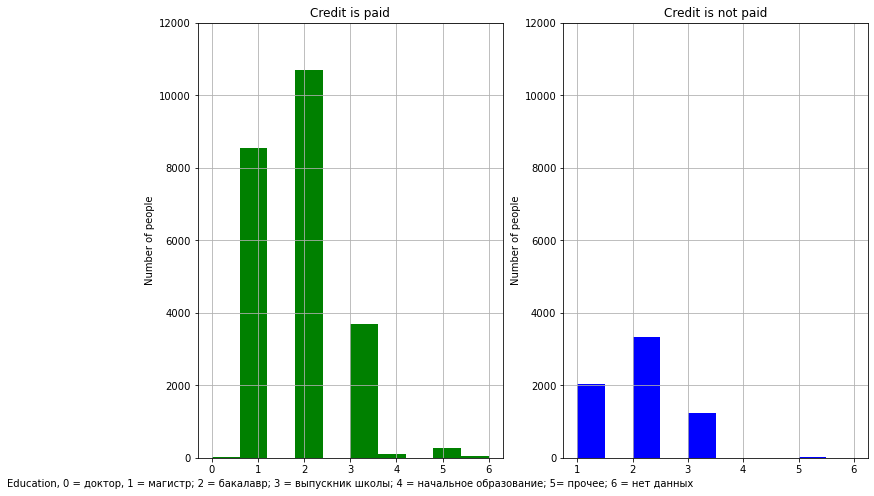

In [123]:
pylab.figure(figsize=(12,8))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(credit_return.EDUCATION, color = 'g')
pylab.ylim(0,12000)
pylab.xlabel('Education, 0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных')
pylab.ylabel('Number of people')
pylab.title('Credit is paid')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(credit_not_return.EDUCATION, color = 'b')
pylab.ylim(0,12000)
#pylab.xlabel('Education, 0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных')
pylab.ylabel('Number of people')
pylab.title('Credit is not paid')

pylab.show()

Как видим, в обоих группах прпобладает количество людей, закончивших бакалавриат. Но нам это ничего не дает, мы хотим понять, влияет ли образование на то, вернул человек кредит или нет.


Для начала составим таблицу сопряженности "образование" на "возврат долга", где значением ячейки будут наблюдаемое и ожидаемое количеством человек. Наблюдаемое количество людей, выплативших кредит - количество выплативших на самом деле (то, что изначальео дано в датасете). Ожидаемое же количество людей, выплативших кредит - это количество всех людей, умноженное на средний процент людей, выплачивающих кредит. Поэтому сначала найдем этот процент, затем построим таблицу.

In [124]:
all_percents = []
for i in range(7):
    all_percents.append(credit_return[credit_return['EDUCATION']==i].shape[0]/(credit_not_return[credit_not_return['EDUCATION']==i].shape[0] + credit_return[credit_return['EDUCATION']==i].shape[0]))
ecp_percent = sum(all_percents)/len(all_percents)
#такой процет людей, взявших кредит, его выплачивает (в среднем)

In [125]:
diff = []
for i in range(7):
    diff.append(ecp_percent*
        (credit_return[credit_return['EDUCATION']==i].shape[0] + credit_not_return[credit_not_return['EDUCATION']==i].shape[0]))

In [126]:
ed = np.array([[credit_return[credit_return['EDUCATION']==0].shape[0], diff[0]]])

for i in range(1,7):
    ed = np.vstack([ed, [credit_return[credit_return['EDUCATION']==i].shape[0], diff[i]]])
    
ed_data = pd.DataFrame(ed, columns=['observed', 'expected'], 
                       index = ['0- доктор','1 - магистр','2-бакалавр','3-выпускник школы', '4-начальное образование','5-прочее', '6-нет данных'])
ed_data

,observed,expected
0- доктор,14.0,12.081337
1 - магистр,8549.0,9134.353886
2-бакалавр,10700.0,12107.225793
3-выпускник школы,3680.0,4243.138220
4-начальное образование,116.0,106.143177
5-прочее,262.0,241.626744
6-нет данных,43.0,44.010586


Теперь проверяем нудевую гипотезу $H_0$ о том, что образование не влияет на вероятность выплаты долга

А $H_1$ - образование влияет

Дркгими словами, нам нужно проверить распределение в образовании на нормальность, для этого восполььзуемся критерием хи-квадрат, но для начала проверим его применимость

In [127]:
stats.chisquare(ed_data['observed'], ed_data['expected'])

Power_divergenceResult(statistic=278.7725391716089, pvalue=2.8770908344926726e-57)

Видим, что значение pvalue очень мало, следовательно нулевая гипотеза отвергается. То есть уровень образования влияет на то, выплатит человек кредит или нет. Рассуждать о том, какие именно группы людей лучше выплачивают кредит сложно, потому что выборки людей с уровнем образования не равным школьному или бакалавру, слишком малы.

### 4

Теперь проверим,  как связан семейный статус с индикатором дефолта.

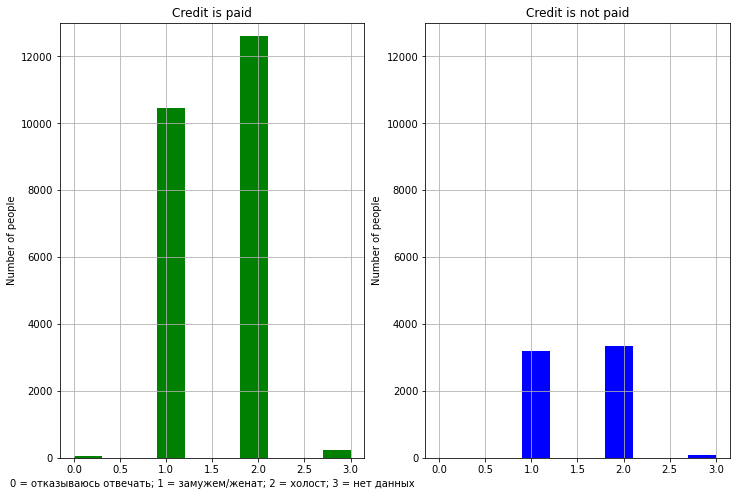

In [128]:
pylab.figure(figsize=(12,8))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(credit_return.MARRIAGE, color = 'g')
pylab.ylim(0,13000)
pylab.xlabel('0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных')
pylab.ylabel('Number of people')
pylab.title('Credit is paid')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(credit_not_return.MARRIAGE, color = 'b')
pylab.ylim(0,13000)
#pylab.xlabel('Education, 0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных')
pylab.ylabel('Number of people')
pylab.title('Credit is not paid')

pylab.show()

In [129]:
mar = np.zeros(shape=(4,2))

for i in range(4):
    mar[i] = [credit_return[credit_return['MARRIAGE']==i].shape[0], credit_not_return[credit_not_return['MARRIAGE']==i].shape[0]]  
mar_data = pd.DataFrame(mar, columns=['paid', 'not paid'], 
                       index = ['0 = отказываюсь отвечать', '1 = замужем/женат', '2 = холост', '3 = нет данных'])
mar_data

,paid,not paid
0 = отказываюсь отвечать,49.0,5.0
1 = замужем/женат,10453.0,3206.0
2 = холост,12623.0,3341.0
3 = нет данных,239.0,84.0


Выше мы составили таблицу сопряженности для категории статуса замужества. Теперь, чтобы понять, связан ли этот критерий с выплатой кредита, посчитаем коэффициент крамера:

In [130]:
(chi2, p, dof, exp) = stats.chi2_contingency(mar)
v_cram = np.sqrt(chi2/(np.sum(mar)*2))
v_cram

0.024379771613073028

Так как коэффициент Крамера близок к нулю, то заимосвязь между статусом замужества и выплатой кредита отсутствует.
Результат практически значим, так как исходя из него при выдаче кредита можно не учитывать статус замужества человека.

### 5

Теперь относительно двух групп людей  вернувших и не вернувших кредит  проверим следующие гипотезы:   
a)  о равенстве медианных значений возрастов людей   
b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  

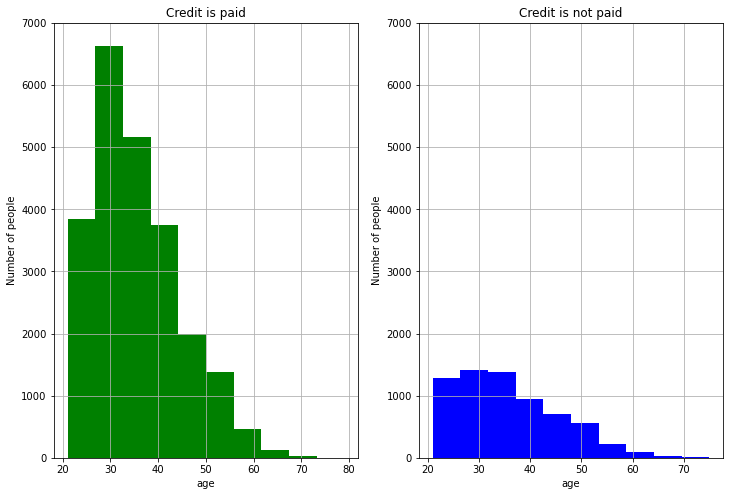

In [131]:
pylab.figure(figsize=(12,8))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(credit_return.AGE, color = 'g')
pylab.ylim(0,7000)
pylab.xlabel('age')
pylab.ylabel('Number of people')
pylab.title('Credit is paid')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(credit_not_return.AGE, color = 'b')
pylab.ylim(0,7000)
pylab.xlabel('age')
pylab.ylabel('Number of people')
pylab.title('Credit is not paid')

pylab.show()

Сложно анализировать эти графики, поэтому сразу перейдем к аналитическому анализу.

Нулевая гипотеза $H_0$ - медианные значения первой и второй группы равны

Двусторонняя альтернатива $H_1$ - не равны

Для начала используем просто двувыборончый критерий для независимых выборок (также как мы делали для кредитного лимита)

In [132]:
print('95%% доверительный интервал для группы людей, выплативших кредит: [%f, %f]' % zconfint(credit_return.AGE))
print('95%% доверительный интервал для группы людей, не выплативших кредит: [%f, %f]' % zconfint(credit_not_return.AGE))

95% доверительный интервал для группы людей, выплативших кредит: [35.300871, 35.533661]
95% доверительный интервал для группы людей, не выплативших кредит: [35.492515, 35.958962]


In [133]:
print('95%% доверительный интервал для группы людей, выплативших кредит:', stat_intervals(get_bootstrap_samples(np.array(credit_return.AGE), 1000).mean(axis = 1), 0.05))
print('95%% доверительный интервал для группы людей, не выплативших кредит:', stat_intervals(get_bootstrap_samples(np.array(credit_not_return.AGE), 1000).mean(axis = 1), 0.05))

95%% доверительный интервал для группы людей, выплативших кредит: [35.30438602 35.52987502]
95%% доверительный интервал для группы людей, не выплативших кредит: [35.5013487  35.95164632]


Как видим, оба способа показали, что доверительные интервалы пересекаются, а значит наша нулевая гипотеза верна.

Можем также просто посчитать медиану обеих групп

In [134]:
print('Median for paid credit', np.median(credit_return.AGE))
print('Median for not paid credit', np.median(credit_not_return.AGE))

Median for paid credit 34.0
Median for not paid credit 34.0


Медианы совпали, что еще раз подверждает нашу гипотезу. 

Таким образом, медианных значений возрастов людей равны

Чтобы проверить гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних, воспользуемся функциями из пукнта 1 (перестановочным критерием.

Нулевая гипотеза $H_0$ - распределения выборок людей, вернувших и невернувыших кредит, равны

Двусторонняя альтернатива $H_1$ -  не равны

In [135]:
print('p-value:', permutation_test(credit_return.AGE, credit_not_return.AGE, max_permutations=1000))

p-value: 0.023


Видим, что нулевая гипотеза отвергается на уровне значимсти 0.05. Поэтому распределения выборрок не равны, несмотря на то, что медианы вышли одинаковыми.